In [28]:
import itertools
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import pyproj
import numpy as np
from sklearn.model_selection import KFold
from dask.distributed import Client
import verde as vd
from vector3d import Vector3D, vector3d_jacobian
from vector3d.utils import plot_data, combinations, sample_from_grid

In [2]:
data = vd.datasets.fetch_california_gps().rename(columns=dict(
    velocity_east='east_velocity', velocity_north='north_velocity', velocity_up='up_velocity'))
region = vd.get_region((data.longitude, data.latitude))
# Convert from m/yr to mm/yr
for comp in ['east_velocity', 'north_velocity', 'up_velocity']:
    data[comp] = 1e3*data[comp]
proj = pyproj.Proj(proj='merc', lat_ts=data.latitude.mean())

In [3]:
data.up_velocity.min(), data.up_velocity.max()

(-52.07000000000001, 10.319999999999999)

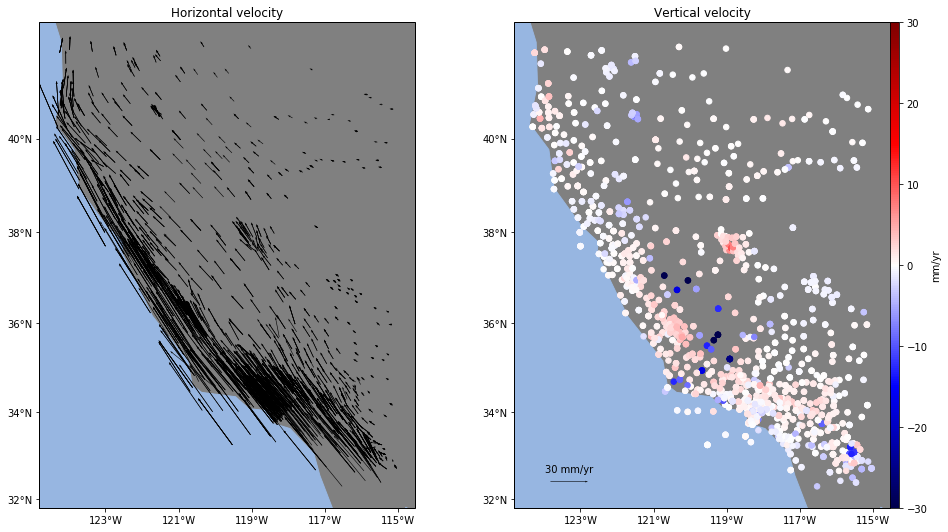

In [4]:
fig, ax = plot_data(data, maxabs=30, pad=0.5, s=30)

## Split the data and make some utility function

In [5]:
full_data = (proj(data.longitude.values, data.latitude.values), 
             (data.east_velocity, data.north_velocity, data.up_velocity))
train, test = vd.train_test_split(*full_data, random_state=0)

In [6]:
train[1][0].size

2212

In [7]:
test[1][0].size

246

In [8]:
def make_residuals(gridder):
    predicted = gridder.predict(proj(data.longitude.values, data.latitude.values))
    res = data.copy()    
    names = ['east_velocity', 'north_velocity', 'up_velocity']
    for pred, name in zip(predicted, names):
        res[name] = data[name] - pred
    return res

In [9]:
def make_grid(gridder):
    grid = gridder.grid(region=region, spacing=spacing, projection=proj,
                        dims=['latitude', 'longitude'], 
                        data_names=['east_velocity', 'north_velocity', 'up_velocity'])
    mask = vd.distance_mask((data.longitude, data.latitude), maxdist=0.5, 
                            region=region, spacing=spacing)
    grid = grid.where(mask)
    return grid

In [10]:
spacing = 5/60

## Simple fit

In [38]:
chain = vd.Chain([
    ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
    ('trend', vd.VectorTrend(1)),
    ('spline', Vector3D(depth=20e3, poisson=0.5, damping=1e1))
])
chain.fit(*train)
score = chain.score(*test)
print("R2 score:", score)
chain.fit(*full_data)

R2 score: 0.9298538726817012


Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f5920103d08>, region=None,
      spacing=8333.333333333332)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=10.0, depth=20000.0, flip_vertical=False, fudge=1e-05,
     poisson=0.5, region=None, shape=None, spacing=None))])

In [12]:
grid = make_grid(chain)

/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


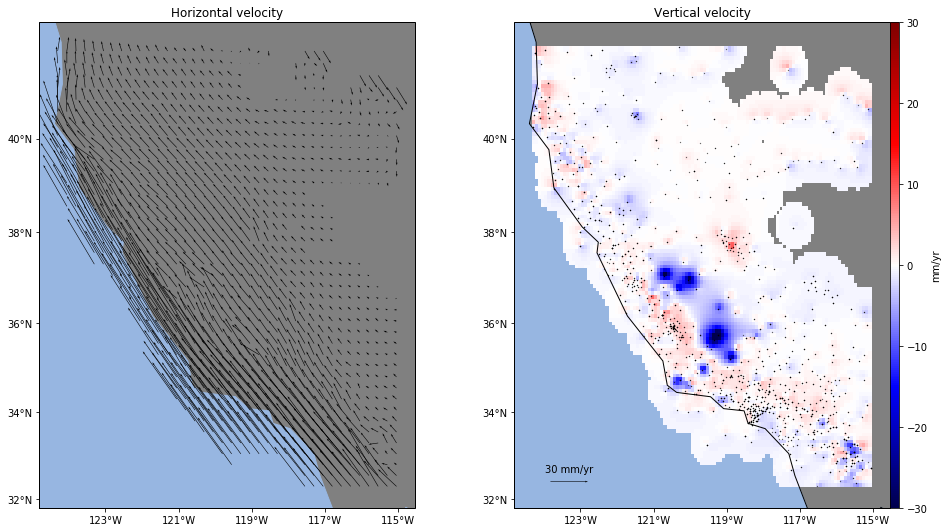

In [13]:
fig, axes = plot_data(grid, every=3, maxabs=30, pad=0.5)
axes[1].plot(data.longitude, data.latitude, '.k', markersize=0.5, transform=ccrs.PlateCarree())

In [14]:
residuals = make_residuals(chain)

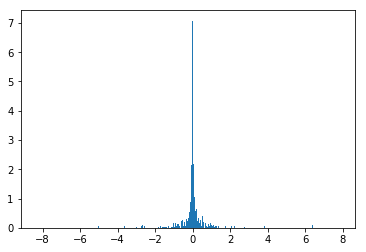

In [15]:
_ = plt.hist(residuals.up_velocity, bins='auto', density=True)

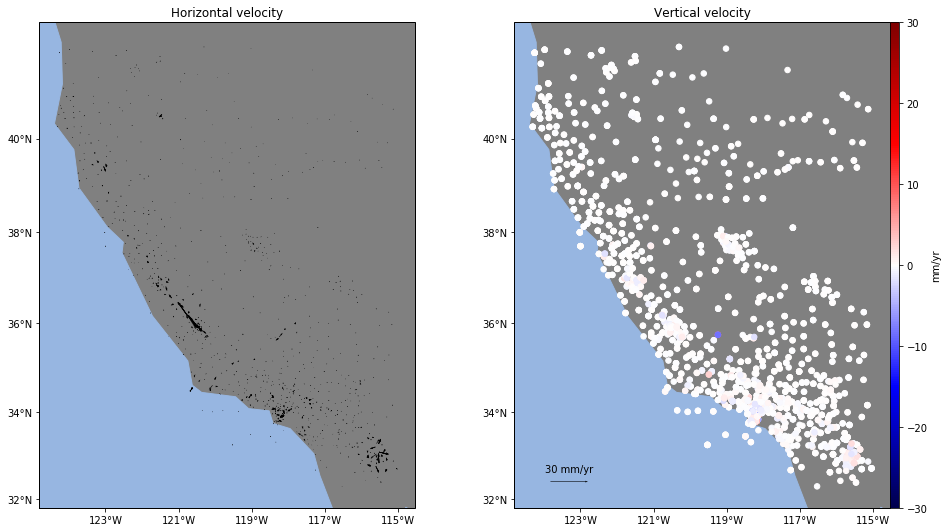

In [16]:
_ = plot_data(residuals, pad=0.5, s=30, maxabs=30)

## Cross-validated

In [17]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37917 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 16.70 GB


In [18]:
def fit_score(estimator, train, test):
    "Fit and score an estimator on the given arguments"
    return estimator.fit(*train).score(*test)

In [42]:
%%time
proj_region = vd.project_region(vd.pad_region(region, spacing*2), proj)

param_grid = combinations(
    spacing=[spacing*100e3*factor for factor in [3, 3.5, 4, 4.5, 5]],
    damping=[10**i for i in range(-1, 3, 1)],
    depth=[10e3, 20e3, 50e3],
    poisson=[-1, 0, 0.5],
)
print("spacings:", set(i['spacing'] for i in param_grid))

chains = []
scores = []
for params in param_grid:
    chain = vd.Chain([
        ('mean', vd.BlockReduce(np.mean, spacing=spacing*100e3)),
        ('trend', vd.VectorTrend(1)),
        ('spline', Vector3D(region=proj_region, **params))
    ])
    chains.append(chain)
    score = vd.cross_val_score(chain, *full_data, client=client, 
                               cv=KFold(shuffle=True, random_state=0))
    scores.append(client.submit(np.mean, score))
best = client.submit(np.argmax, scores).result()
print("\nBest score:", scores[best].result())
cv_chain = chains[best].fit(*full_data)
print("\nBest chain:\n", cv_chain)

spacings: {41666.66666666666, 24999.999999999996, 29166.666666666664, 33333.33333333333, 37499.99999999999}

Best score: 0.9225854393177627


/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/verde/spline.py:150: UserWarning: Under-determined problem detected (ndata, nparams)=(2274, 4968). Configuration of forces: spacing=24999.999999999996 shape=None
  "spacing={} shape={}".format(self.spacing, self.shape)]))



Best chain:
 Chain(steps=[('mean', BlockReduce(adjust='spacing', center_coordinates=False,
      reduction=<function mean at 0x7f5920103d08>, region=None,
      spacing=8333.333333333332)), ('trend', VectorTrend(degree=1)), ('spline', Vector3D(damping=10, depth=10000.0, flip_vertical=False, fudge=1e-05,
     poisson=0,
     region=(-11216811.477464048, -10350859.57800579, 3040960.606075709, 4163002.708724454),
     shape=None, spacing=24999.999999999996))])
CPU times: user 49 s, sys: 4.65 s, total: 53.6 s
Wall time: 4min 29s


In [43]:
grid = make_grid(cv_chain)

/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/leo/miniconda3/envs/aogs2018-gps/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


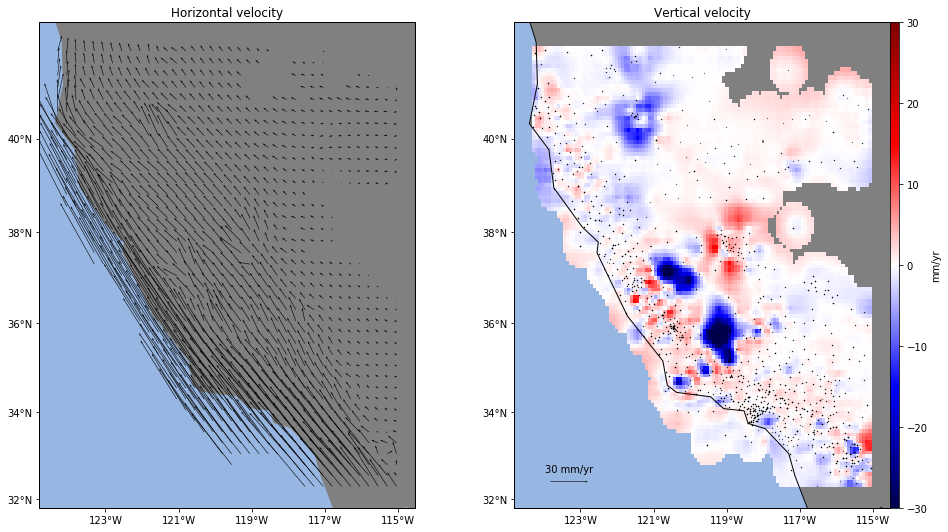

In [44]:
fig, axes = plot_data(grid, every=3, maxabs=30, pad=0.5)
axes[1].plot(data.longitude, data.latitude, '.k', markersize=0.5, transform=ccrs.PlateCarree())

In [48]:
residuals = make_residuals(cv_chain)

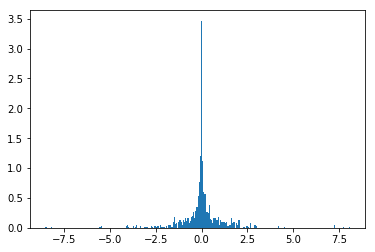

In [49]:
_ = plt.hist(residuals.up_velocity, bins='auto', density=True)

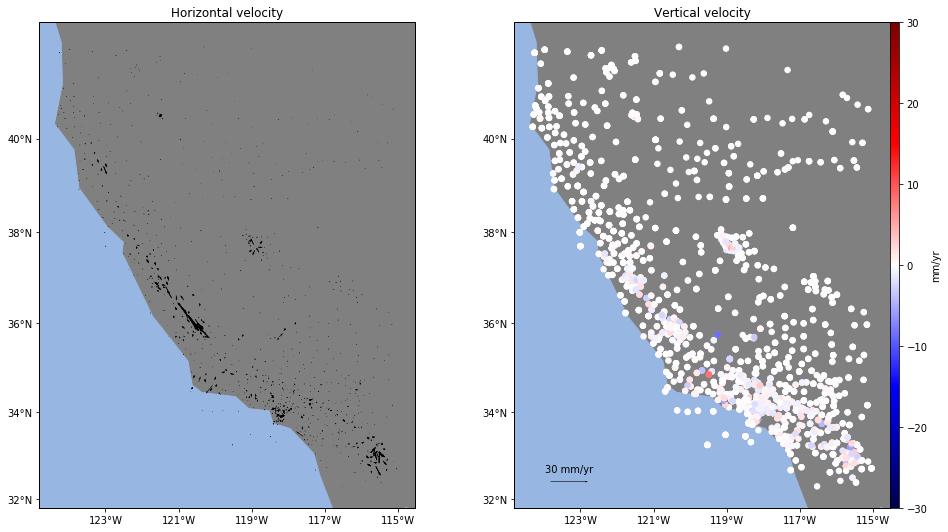

In [50]:
_ = plot_data(residuals, pad=0.5, s=30, maxabs=30)